# Stream active learning cycle with verification latency
In this notebook, we will show how stream-based active learning strategies related to verification latency are compared. We showcase the methods available in the delay_wrapper package. 

In [1]:
import sys
sys.path.append('../..')

import pdb
import numpy as np
import sklearn
import sklearn.datasets
import matplotlib.pyplot as plt
import copy

from collections import deque
from skactiveml.classifier import PWC
from skactiveml.stream import RandomSampler, PeriodicSampler
from skactiveml.stream import FixedUncertainty, VariableUncertainty, Split, PAL
from skactiveml.stream.budget_manager import FixedBudget, BIQF
from skactiveml.stream.verification_latency import BaggingDelaySimulationWrapper, ForgettingWrapper, FuzzyDelaySimulationWrapper
from skactiveml.utils import check_random_state

## Initialize stream parameters 
Before the experiments can start, we need to construct a random data set. For this, we specify the necessary parameters in the cell below. To make the experiment repeatable, we will use the random_state object to generate all other random seeds, such that we only need to explicitely specify a single random seed. Furthermore, we specify the length of the data stream (stream_length), the size of the sliding window that defines the available training data (training_size) and the globally present verification latency, that affects all label acquisition equally).

In [2]:
# random state that is used to generate random seeds
random_state = np.random.RandomState(0)
# number of instances that are provided to the classifier
init_train_length = 10
# the length of the data stream
stream_length = 5000
# the size of the sliding window that limits the training data
training_size = 1000
# the verification latency occuring after querying a label
verification_latency = 300

## Random seed generation
The get_randomseed function simplifies the generation of a new random seed from a given random state object. For this notebook, this random state object will be always the random_state obejct defined above.

In [3]:
def get_randomseed(random_state):
    return random_state.randint(2**31-1)

## Generate and initialize data set
The next block initializes the tested data set. We use scikit-learn to generate a random dataset with our pre-defined stream length. The data set consists of multiple parts. X represents the intances location within the feature space. The class for each instance is denoted by y. Furthermore, we need timestamps to be able to model the verification latency. In this notebook we show the effects of a constant verification latency, however, a verification latency per instance basis can be done by replacing the scalar value of verification_latency by a vector with an entry per instance. We distinguish between timestamps for an instance (tX) and the corresponding label (ty). Hence, given a query to sample the label y\[i\] for instance X\[i\] that occurs at tX\[i\], we will be able to incorporate the label y\[i\] beginning from ty\[i\].
For models that need at least some initial training data, we generate samples to train an initial model. These are denoted by the suffix "_init", while all data used within the active learning cycle are denoted by the suffix "_stream".

In [4]:
# create the data stream
X, center = sklearn.datasets.make_blobs(n_samples=init_train_length + stream_length, centers=30, random_state=get_randomseed(random_state), shuffle=True)
y = center % 2
X_init = X[:init_train_length, :]
y_init = y[:init_train_length]
X_stream = X[init_train_length:, :]
y_stream = y[init_train_length:]
# create the time stamps
tX = np.arange(stream_length)
ty = tX + verification_latency
tX_init = tX[:init_train_length]
ty_init = ty[:init_train_length]
tX_stream = tX[init_train_length:]
ty_stream = ty[init_train_length:]


## Initialize parameters for delay wrappers
After initializing the dataset, we have to specify the parameters for each query strategy. 
K is used in BaggingDelaySimulationWrapper to specify the number of repeated simulations. The ForgettingWrapper uses w_train to assess the data that will still be available after the verification latency.  
The delay_prior regularizes the class probability assessment used within BaggingDelaySimulationWrapper and FuzzyDelaySimulationWrapper.

In [5]:
K = 2
w_train = training_size
delay_prior = 0.001

## Initialize query strategies
Next, we initialize the classifier and the base query strategies that we want to compare. The base query strategies will be wrapped within one or multiple of the delay wrappers later on to make them aware of the verification latency. To guarantee that the classifier and the query strategies are not affected by previous repetitions, we use factory functions to separate the objects for each experiment run.

In [6]:
clf_factory = lambda: PWC(classes=[0,1], random_state= get_randomseed(random_state))
missing_label = clf_factory().missing_label
query_strategies_factories = {
    # 'VariableUncertainty': VariableUncertainty(clf=clf, random_state=get_randomseed(random_state)),
    'Split': lambda: Split(clf=clf_factory(), random_state=get_randomseed(random_state)),
    'PAL': lambda: PAL(clf=clf_factory(), random_state=get_randomseed(random_state), budget_manager=BIQF( w=256, w_tol=20, budget=None, save_utilities=True))
}

## Start the active learning cycle
After all variables are initialized, we can start the experiment. The experiment loop below goes through all query strategies defined in query_strategies and use no delay wrapper (None), ForgettingWrapper, BaggingDelaySimulationWrapper, and FuzzyDelaySimulationWrapper on each strategy. For each experiment run, the average accuracy the selected query strategies will be displayed. Lastly, the accuracy over time will be plotted.

Query Strategy:  Split
Delay Wrapper:  None , Avg Accuracy:  0.693 , Number of acquired instances:  522
Delay Wrapper:  Forgetting , Avg Accuracy:  0.7116 , Number of acquired instances:  522
Delay Wrapper:  BaggingDelaySimulation , Avg Accuracy:  0.6926 , Number of acquired instances:  522
Delay Wrapper:  FuzzyDelaySimulation , Avg Accuracy:  0.709 , Number of acquired instances:  523
Delay Wrapper:  Forgetting + Bagging , Avg Accuracy:  0.7212 , Number of acquired instances:  522
Delay Wrapper:  Forgetting + Fuzzy , Avg Accuracy:  0.703 , Number of acquired instances:  522


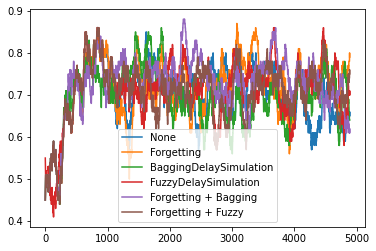

Query Strategy:  PAL
Delay Wrapper:  None , Avg Accuracy:  0.6844 , Number of acquired instances:  1196
Delay Wrapper:  Forgetting , Avg Accuracy:  0.7394 , Number of acquired instances:  1202
Delay Wrapper:  BaggingDelaySimulation , Avg Accuracy:  0.7402 , Number of acquired instances:  497
Delay Wrapper:  FuzzyDelaySimulation , Avg Accuracy:  0.7438 , Number of acquired instances:  497
Delay Wrapper:  Forgetting + Bagging , Avg Accuracy:  0.7706 , Number of acquired instances:  500
Delay Wrapper:  Forgetting + Fuzzy , Avg Accuracy:  0.7648 , Number of acquired instances:  495


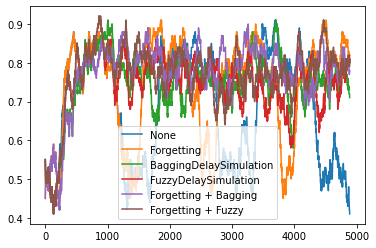

In [7]:
for query_strategy_name, query_strategy_factory in query_strategies_factories.items():
    delay_wrappers_factories = {
        'None': lambda qs: qs,
        'Forgetting': lambda qs: ForgettingWrapper(base_query_strategy=qs, w_train=w_train, random_state=get_randomseed(random_state)),
        'BaggingDelaySimulation': lambda qs: BaggingDelaySimulationWrapper(base_query_strategy=qs, random_state=get_randomseed(random_state), K=K,  delay_prior=delay_prior, clf=clf_factory()),
        'FuzzyDelaySimulation': lambda qs: FuzzyDelaySimulationWrapper(base_query_strategy=qs, random_state=get_randomseed(random_state),  delay_prior=delay_prior, clf=clf_factory())
    }
    delay_wrappers_factories["Forgetting + Bagging"] = lambda qs: delay_wrappers_factories["Forgetting"](delay_wrappers_factories["BaggingDelaySimulation"](qs))
    delay_wrappers_factories["Forgetting + Fuzzy"] = lambda qs: delay_wrappers_factories["Forgetting"](delay_wrappers_factories["FuzzyDelaySimulation"](qs))
    print("Query Strategy: ",query_strategy_name,)
    for delay_wrapper_name, delay_wrapper_factory in delay_wrappers_factories.items():
        clf = clf_factory()
        # initializing the query strategy
        delay_wrapper = delay_wrapper_factory(query_strategy_factory())
        # initializing the training data
        X_train = deque(maxlen=training_size)
        X_train.extend(X_init)
        y_train = deque(maxlen=training_size)
        y_train.extend(y_init)
        # initialize the time stamps corresponding to the training data
        tX_train = deque(maxlen=training_size)
        tX_train.extend(tX_init)
        ty_train = deque(maxlen=training_size)
        ty_train.extend(ty_init)
        # initializing the acquisition vector
        acquisitions = deque(maxlen=training_size)
        acquisitions.extend(np.full(len(y_train),True))
        # train the model with the initially available data
        clf.fit(X_train, y_train)
        # initialize the list that stores the result of the classifier's prediction
        correct_classifications = []
        # initialize the number of acquired labels
        count = 0
        # iterate over the whole data stream
        for t, (X_cand, y_cand , tX_cand, ty_cand) in enumerate(zip(X_stream, y_stream, tX_stream, ty_stream)):
            # infer the currently available labels
            # missing_label is used to denote unlabeled instances
            y_train_current = np.array([y if ty < tX_cand and a else missing_label for ty, y, a in zip (ty_train, y_train, acquisitions)])
            # train the classifier
            clf.fit(np.array(X_train), np.array(y_train_current))
            # evaluate the prediction of the classifier
            correct_classifications.append(clf.predict(X_cand.reshape([1, -1]))[0] == y_cand)
            # check whether to sample the instance or not
            sampled_indices = delay_wrapper.query(X_cand.reshape([1, -1]), X=np.array(X_train), y=np.array(y_train_current), tX=np.array(tX_train), ty=np.array(ty_train), tX_cand=[tX_cand], ty_cand=[ty_cand], return_utilities=False, acquisitions=acquisitions)
            
            # set the entry within the acquisition vector according to the query strategy's decision
            acquisitions.append((len(sampled_indices) > 0) )
            if len(sampled_indices):
                count += 1
            
            # add the current instance to the training data
            tX_train.append(tX_cand)
            ty_train.append(ty_cand)
            X_train.append(X_cand)
            y_train.append(y_cand)
        # calculate and show the average accuracy 
        print("Delay Wrapper: ", delay_wrapper_name, ", Avg Accuracy: ", np.sum(correct_classifications)/stream_length,  ", Number of acquired instances: ", count)
        # smoothing the accuracy for plotting
        smoothing_window_length = 100
        cumsum_correct_classifications = np.cumsum(correct_classifications)
        plt.plot((cumsum_correct_classifications[smoothing_window_length:]-cumsum_correct_classifications[:-smoothing_window_length])/smoothing_window_length, label=delay_wrapper_name)
    plt.legend()
    plt.show()